# Multiple Seasonal-Trend decomposition using LOESS (MSTL)

This notebook illustrates the use of `MSTL` [1] to decompose a time series into a: trend component, multiple seasonal components, and a residual component. MSTL uses STL (Seasonal-Trend decomposition using LOESS) to iteratively extract seasonal components from a time series. The key inputs into `MSTL` are:

* `periods` - The period of each seasonal component (e.g., for hourly data with daily and weekly seasonality we would have: `periods=(24, 24*7)`.
* `windows` - The lengths of each seasonal smoother with respect to each period. If these are large then the seasonal component will show less variability over time. Must be odd. If `None` a set of default values determined by experiments in the original paper [1] are used.
* `lmbda` - The lambda parameter for a Box-Cox transformation prior to decomposition. If `None` then no transformation is done. If `"auto"` then an appropriate value for lambda is automatically selected from the data.
* `iterate` - Number of iterations to use to refine the seasonal component.
* `stl_kwargs` - All the other parameters which can be passed to STL (e.g., `robust`, `seasonal_deg`, etc.). See [STL docs](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.STL.html).

[1] [K. Bandura, R.J. Hyndman, and C. Bergmeir (2021)
    MSTL: A Seasonal-Trend Decomposition Algorithm for Time Series with Multiple
    Seasonal Patterns. arXiv preprint arXiv:2107.13462.](https://arxiv.org/pdf/2107.13462.pdf)
    
Note there are some key differences in this implementation to [1](https://arxiv.org/pdf/2107.13462.pdf). Missing data must be handled outside of the `MSTL` class. The algorithm proposed in the paper handles a case when there is no seasonality. This implementation assumes that there is at least one seasonal component.

First we import the required packages, prepare the graphics environment, and prepare the data. 

In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

from statsmodels.tsa.seasonal import MSTL, DecomposeResult

register_matplotlib_converters()
sns.set_style("darkgrid")

In [2]:
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

## MSTL applied to a toy dataset 

### Create a toy dataset with multiple seasonalities

We create a time series with hourly frequency that has a daily and weekly seasonality which follow a sine wave. We demonstrate a more real world example later in the notebook.

In [3]:
t = np.arange(1, 1000)
daily_seasonality = 5 * np.sin(2 * np.pi * t / 24)
weekly_seasonality = 10 * np.sin(2 * np.pi * t / (24 * 7))
trend = 0.0001 * t**2
y = trend + daily_seasonality + weekly_seasonality + np.random.randn(len(t))
ts = pd.date_range(start="2020-01-01", freq="h", periods=len(t))
df = pd.DataFrame(data=y, index=ts, columns=["y"])

In [4]:
df.head()

,y
2020-01-01 00:00:00,2.432543
2020-01-01 01:00:00,4.912447
2020-01-01 02:00:00,3.683432
2020-01-01 03:00:00,6.191737
2020-01-01 04:00:00,8.440609


Let's plot the time series

<Axes: >

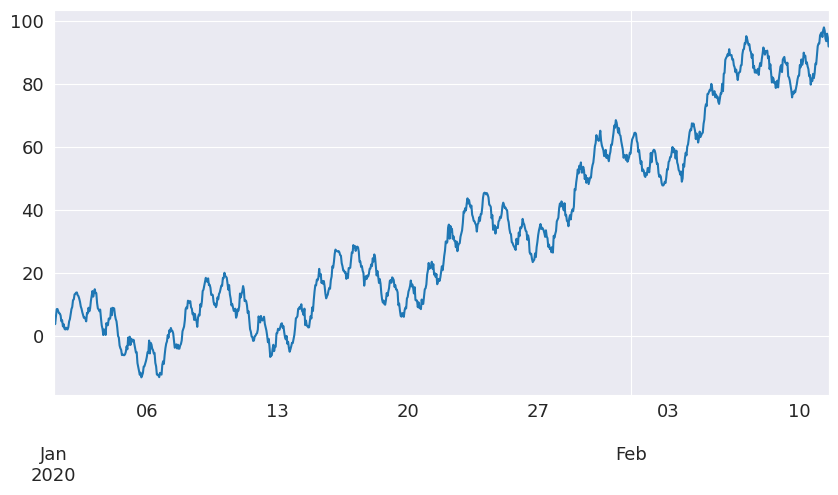

In [5]:
df["y"].plot(figsize=[10, 5])

### Decompose the toy dataset with MSTL

Let's use MSTL to decompose the time series into a trend component, daily and weekly seasonal component, and residual component.

In [6]:
mstl = MSTL(df["y"], periods=[24, 24 * 7])
res = mstl.fit()

If the input is a pandas dataframe then the output for the seasonal component is a dataframe. The period for each component is reflect in the column names.

In [7]:
res.seasonal.head()

,seasonal_24,seasonal_168
2020-01-01 00:00:00,1.468760,0.462946
2020-01-01 01:00:00,3.179448,2.009199
2020-01-01 02:00:00,2.967641,1.474663
2020-01-01 03:00:00,3.539298,2.630025
2020-01-01 04:00:00,5.043197,3.062858


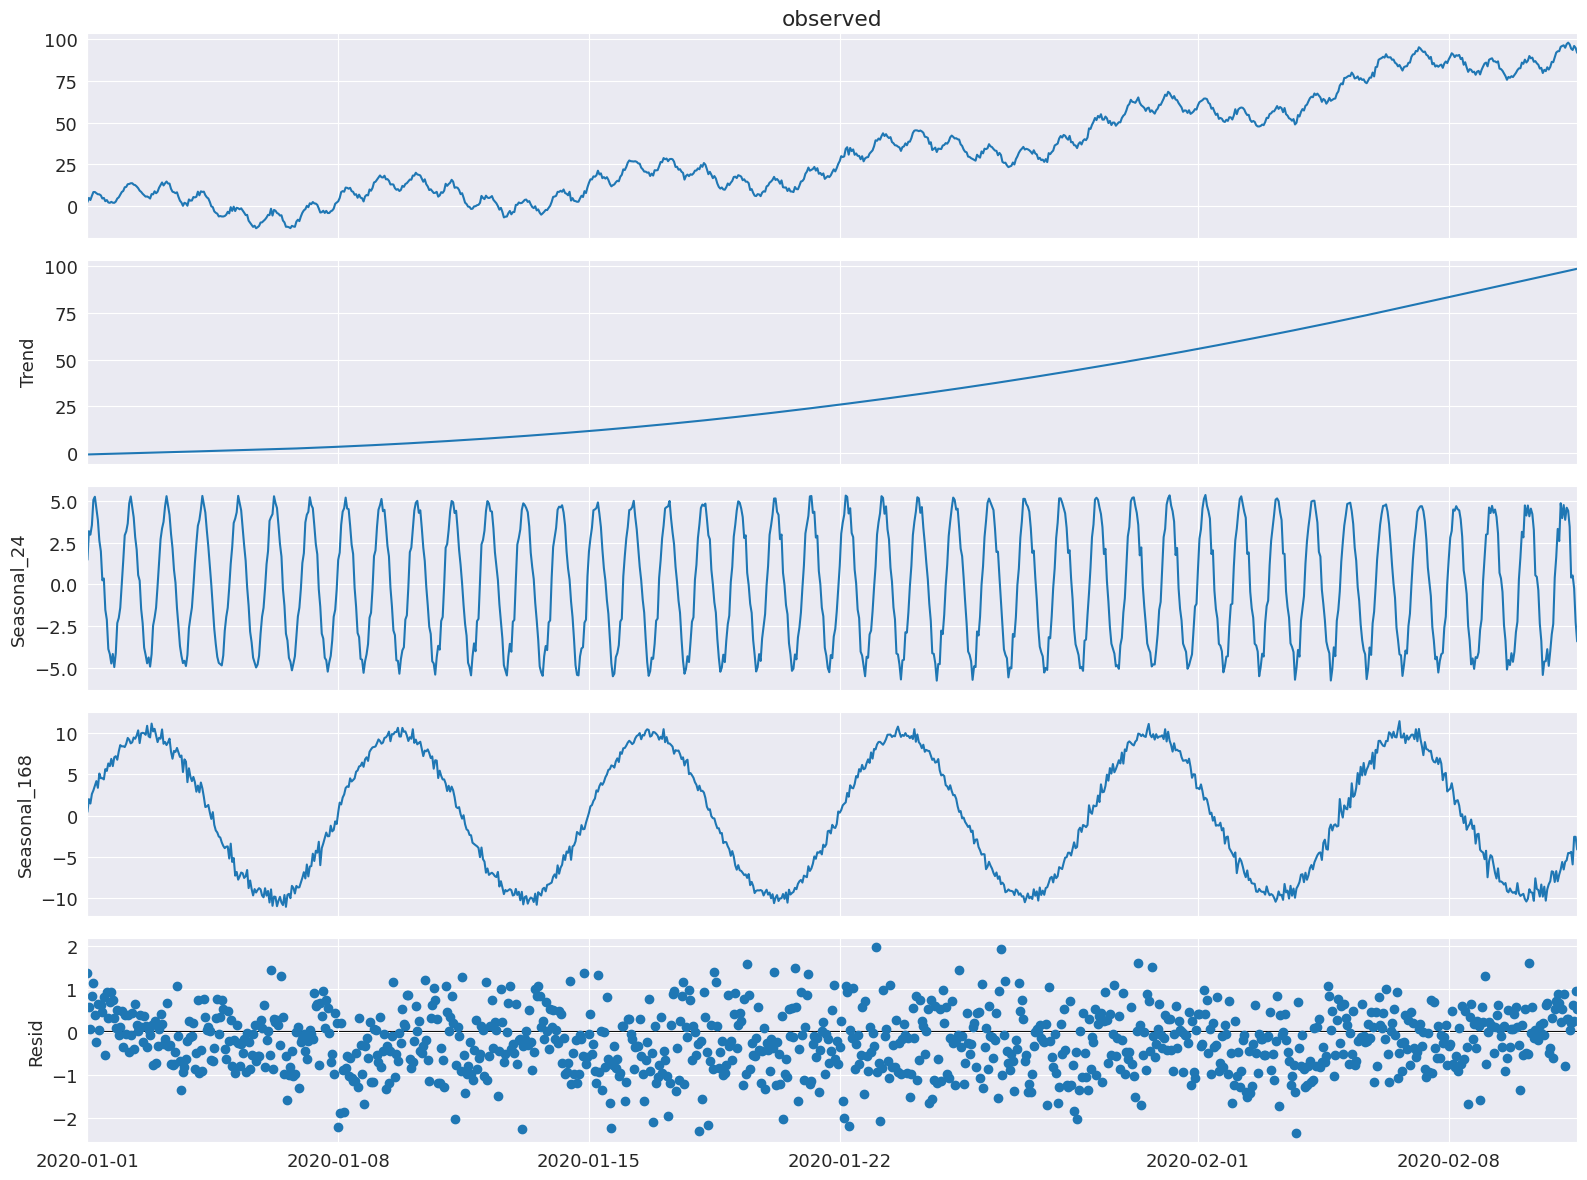

In [8]:
ax = res.plot()

We see that the hourly and weekly seasonal components have been extracted.

Any of the STL parameters other than `period` and `seasonal` (as they are set by `periods` and `windows` in `MSTL`) can also be set by passing arg:value pairs as a dictionary to `stl_kwargs` (we will show that in an example now).

Here we show that we can still set the trend smoother of STL via `trend` and order of the polynomial for the seasonal fit via `seasonal_deg`. We will also explicitly set the `windows`, `seasonal_deg`, and `iterate` parameter explicitly. We will get a worse fit but this is just an example of how to pass these parameters to the `MSTL` class.

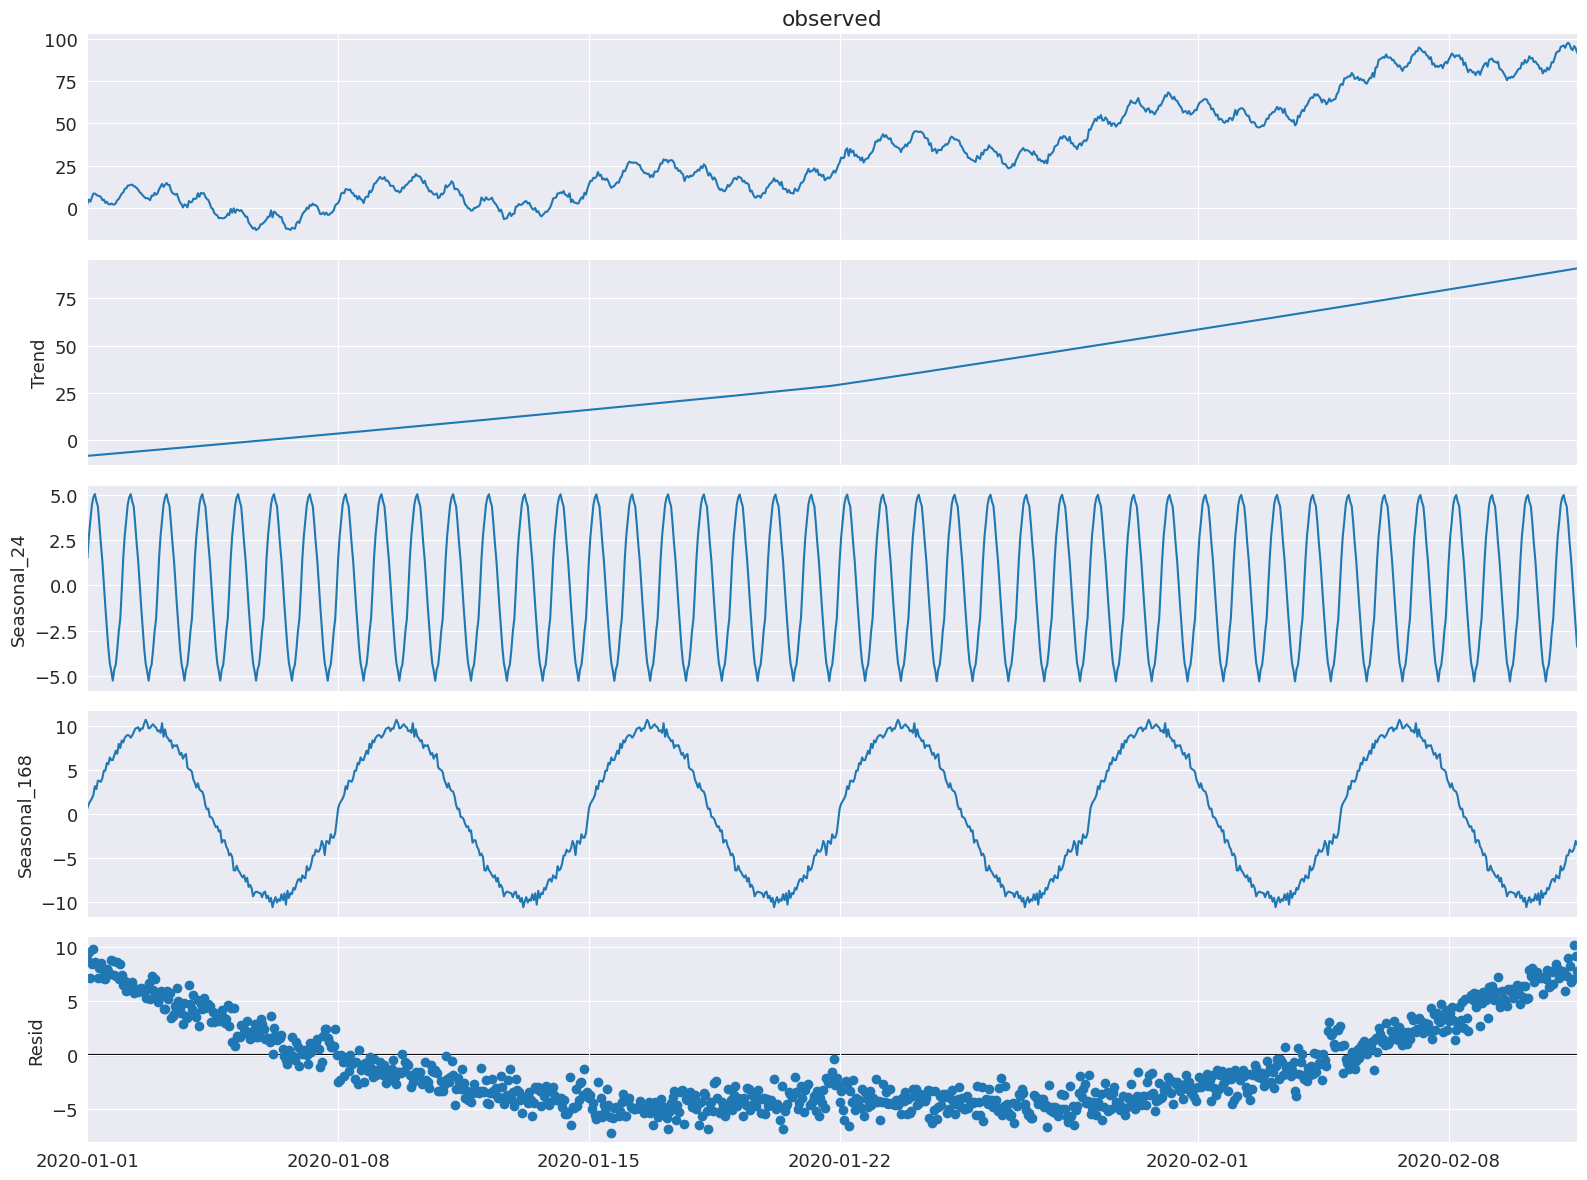

In [9]:
mstl = MSTL(
    df,
    periods=[
        24,
        24 * 7,
    ],  # The periods and windows must be the same length and will correspond to one another.
    windows=[
        101,
        101,
    ],  # Setting this large along with `seasonal_deg=0` will force the seasonality to be periodic.
    iterate=3,
    stl_kwargs={
        "trend": 1001,  # Setting this large will force the trend to be smoother.
        "seasonal_deg": 0,  # Means the seasonal smoother is fit with a moving average.
    },
)
res = mstl.fit()
ax = res.plot()

## MSTL applied to electricity demand dataset

### Prepare the data

We will use the Victoria electricity demand dataset found here: 
https://github.com/tidyverts/tsibbledata/tree/master/data-raw/vic_elec. This dataset is used in the [original MSTL paper [1]](https://arxiv.org/pdf/2107.13462.pdf). It is the total electricity demand at a half hourly granularity for the state of Victora in Australia from 2002 to the start of 2015. A more detailed description of the dataset can be found [here](https://rdrr.io/cran/tsibbledata/man/vic_elec.html).

In [10]:
url = "https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/VIC2015/demand.csv"
df = pd.read_csv(url)

In [11]:
df.head()

,Date,Period,OperationalLessIndustrial,Industrial
0,37257,1,3535.867064,1086.132936
1,37257,2,3383.499028,1088.500972
2,37257,3,3655.527552,1084.472448
3,37257,4,3510.446636,1085.553364
4,37257,5,3294.697156,1081.302844


The date are integers representing the number of days from an origin date. The origin date for this dataset is determined from [here](https://github.com/tidyverts/tsibbledata/blob/master/data-raw/vic_elec/vic_elec.R) and [here](https://robjhyndman.com/hyndsight/electrictsibbles/) and is "1899-12-30". The `Period` integers refer to 30 minute intervals in a 24 hour day, hence there are 48 for each day.



Let's extract the date and date-time.

In [12]:
df["Date"] = df["Date"].apply(
    lambda x: pd.Timestamp("1899-12-30") + pd.Timedelta(x, unit="days")
)
df["ds"] = df["Date"] + pd.to_timedelta((df["Period"] - 1) * 30, unit="m")

We will be interested in `OperationalLessIndustrial` which is the electricity demand excluding the demand from certain high energy industrial users. We will resample the data to hourly and filter the data to the same time period as [original MSTL paper [1]](https://arxiv.org/pdf/2107.13462.pdf) which is the first 149 days of the year 2012.

In [13]:
timeseries = df[["ds", "OperationalLessIndustrial"]]
timeseries.columns = [
    "ds",
    "y",
]  # Rename to OperationalLessIndustrial to y for simplicity.

# Filter for first 149 days of 2012.
start_date = pd.to_datetime("2012-01-01")
end_date = start_date + pd.Timedelta("149D")
mask = (timeseries["ds"] >= start_date) & (timeseries["ds"] < end_date)
timeseries = timeseries[mask]

# Resample to hourly
timeseries = timeseries.set_index("ds").resample("h").sum()
timeseries.head()

,y
ds,
2012-01-01 00:00:00,7926.529376
2012-01-01 01:00:00,7901.826990
2012-01-01 02:00:00,7255.721350
2012-01-01 03:00:00,6792.503352
2012-01-01 04:00:00,6635.984460


### Decompose electricity demand using MSTL

Let's apply MSTL to this dataset.

Note: `stl_kwargs` are set to give results close to [[1]](https://arxiv.org/pdf/2107.13462.pdf) which used R and therefore has a slightly different default settings for the underlying `STL` parameters. It would be rare to manually set `inner_iter` and `outer_iter` explicitly in practice.

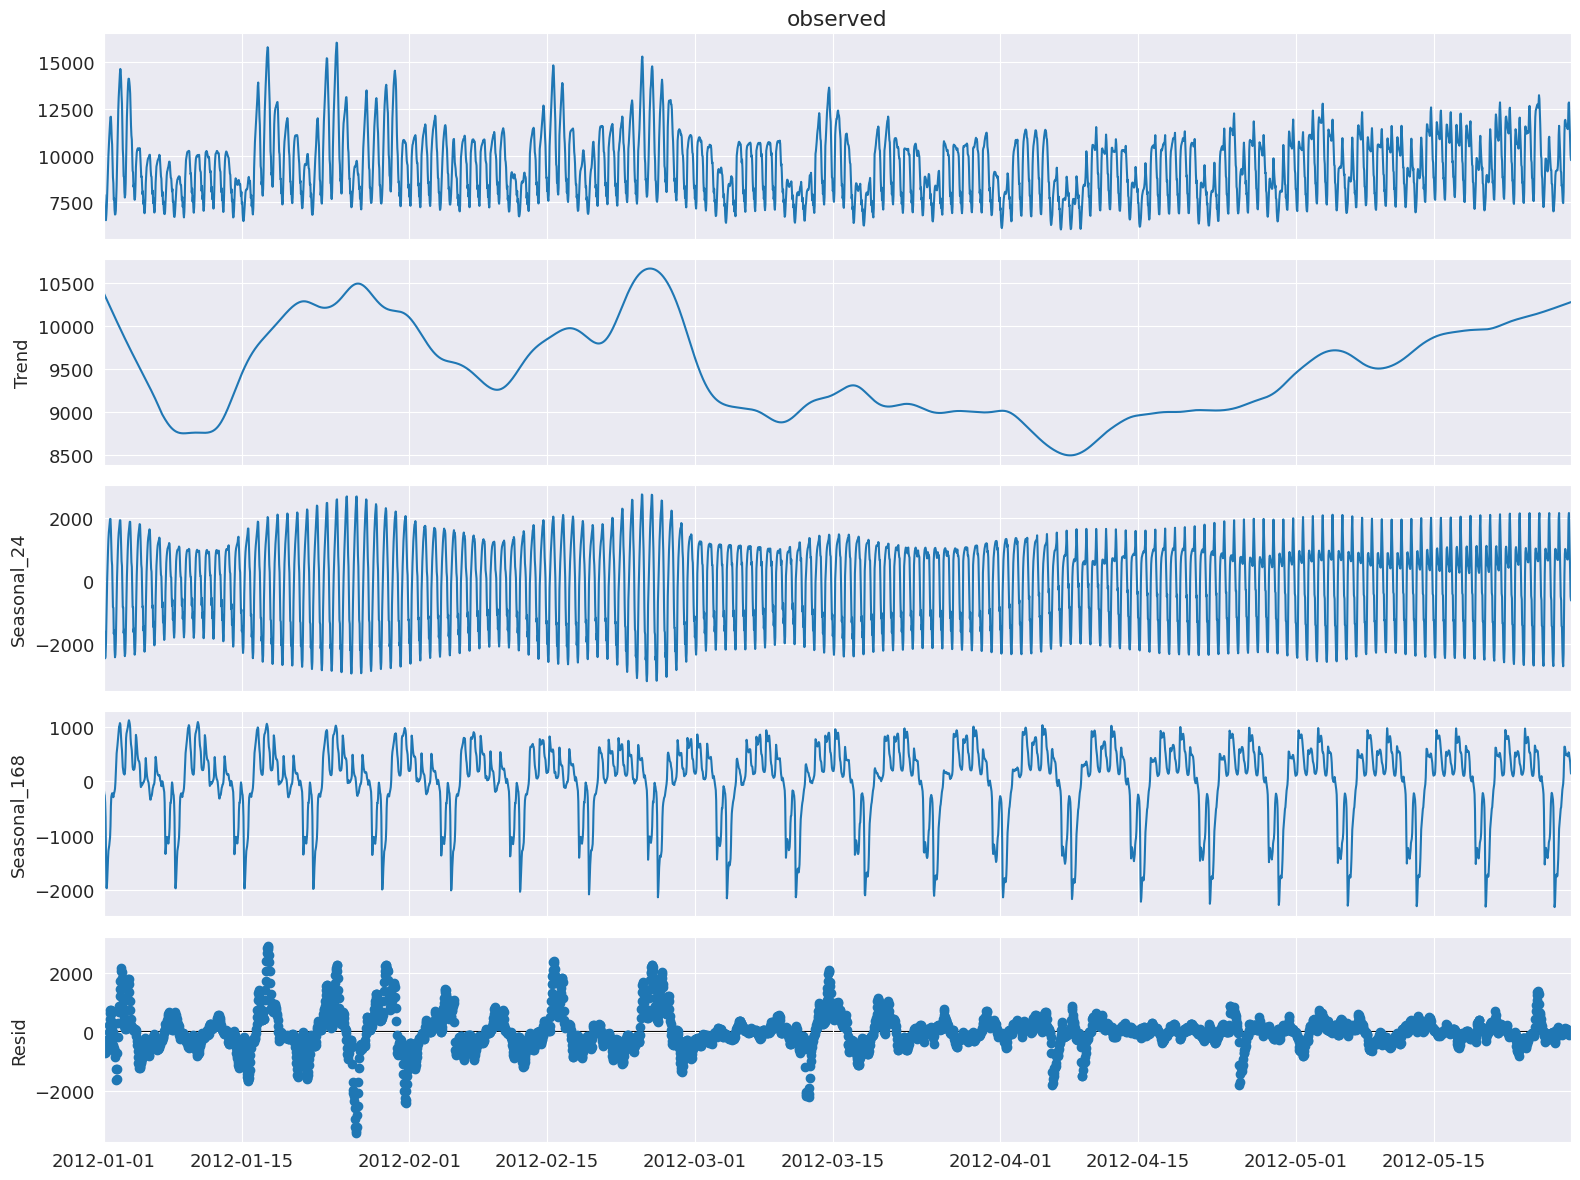

In [14]:
mstl = MSTL(
    timeseries["y"],
    periods=[24, 24 * 7],
    iterate=3,
    stl_kwargs={"seasonal_deg": 0, "inner_iter": 2, "outer_iter": 0},
)
res = mstl.fit()  # Use .fit() to perform and return the decomposition
ax = res.plot()
plt.tight_layout()

The multiple seasonal components are stored as a pandas dataframe in the `seasonal` attribute:

In [15]:
res.seasonal.head()

,seasonal_24,seasonal_168
ds,,
2012-01-01 00:00:00,-1685.986297,-161.807086
2012-01-01 01:00:00,-1591.640845,-229.788887
2012-01-01 02:00:00,-2192.989492,-260.121300
2012-01-01 03:00:00,-2442.169359,-388.484499
2012-01-01 04:00:00,-2357.492551,-660.245476


Let's inspect the seasonal components in a bit more detail and look at the first few days and weeks to examine the daily and weekly seasonality. 

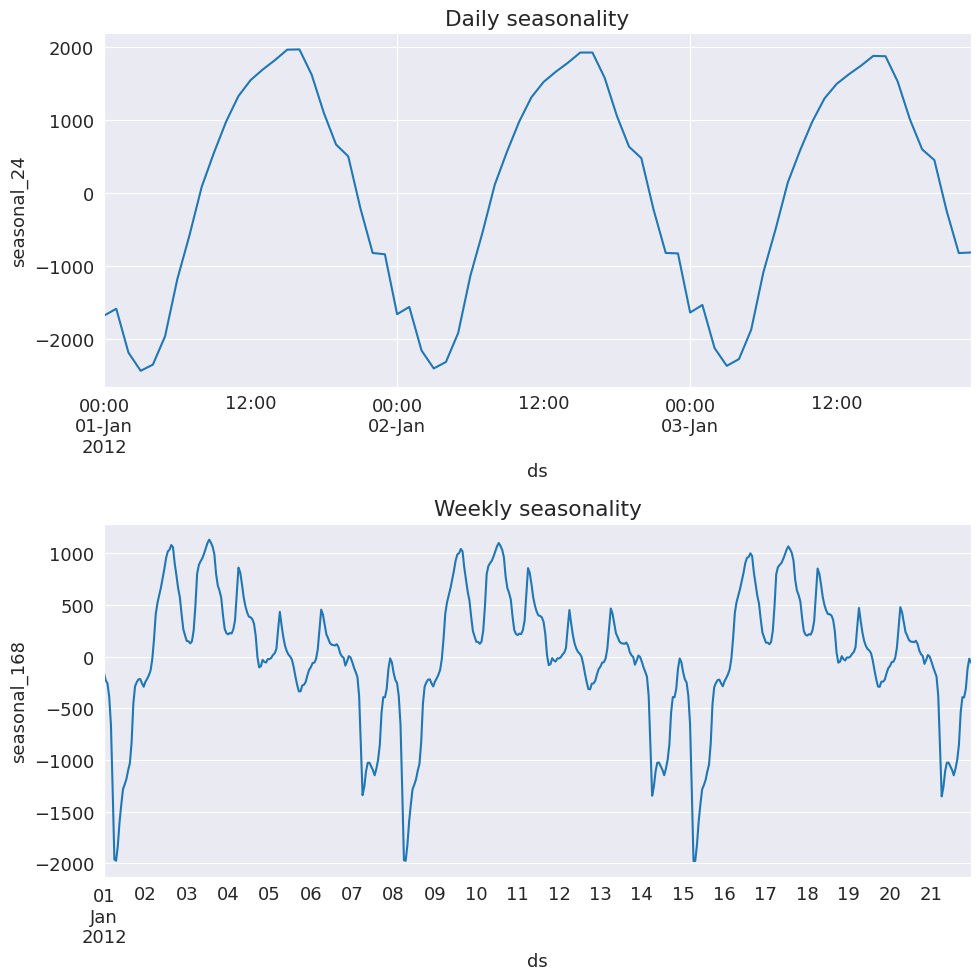

In [16]:
fig, ax = plt.subplots(nrows=2, figsize=[10, 10])
res.seasonal["seasonal_24"].iloc[: 24 * 3].plot(ax=ax[0])
ax[0].set_ylabel("seasonal_24")
ax[0].set_title("Daily seasonality")

res.seasonal["seasonal_168"].iloc[: 24 * 7 * 3].plot(ax=ax[1])
ax[1].set_ylabel("seasonal_168")
ax[1].set_title("Weekly seasonality")

plt.tight_layout()

We can see that the daily seasonality of electricity demand is well captured. This is the first few days in January so during the summer months in Australia there is a peak in the afternoon most likely due to air conditioning use. 

For the weekly seasonality we can see that there is less usage during the weekends.

One of the advantages of MSTL is that is allows us to capture seasonality which changes over time. So let's look at the seasonality during cooler months in May.

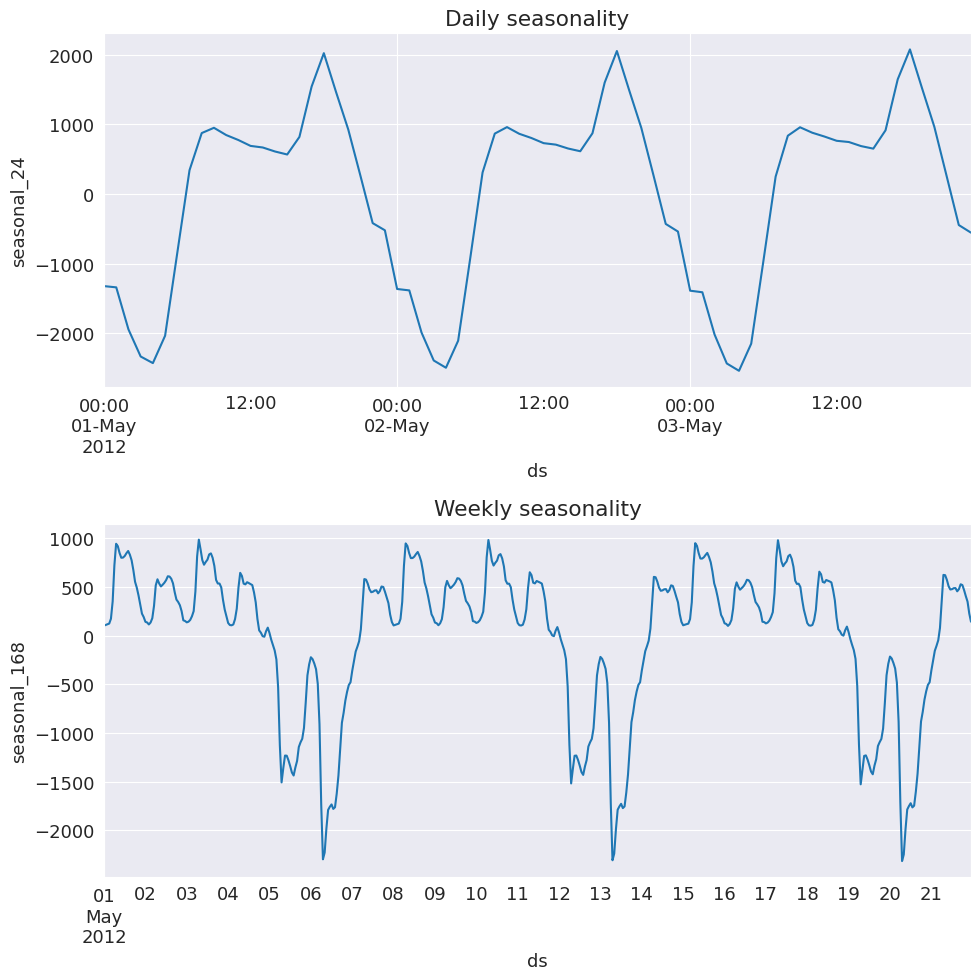

In [17]:
fig, ax = plt.subplots(nrows=2, figsize=[10, 10])
mask = res.seasonal.index.month == 5
res.seasonal[mask]["seasonal_24"].iloc[: 24 * 3].plot(ax=ax[0])
ax[0].set_ylabel("seasonal_24")
ax[0].set_title("Daily seasonality")

res.seasonal[mask]["seasonal_168"].iloc[: 24 * 7 * 3].plot(ax=ax[1])
ax[1].set_ylabel("seasonal_168")
ax[1].set_title("Weekly seasonality")

plt.tight_layout()

Now we can see an additional peak in the evening! This could be related to heating and lighting now required in the evenings. So this makes sense. We see that main weekly pattern of lower demand over the weekends continue.

The other components can also be extracted from the `trend` and `resid` attribute:

In [18]:
display(res.trend.head())  # trend component
display(res.resid.head())  # residual component

ds
2012-01-01 00:00:00    10373.942662
2012-01-01 01:00:00    10363.488489
2012-01-01 02:00:00    10353.037721
2012-01-01 03:00:00    10342.590527
2012-01-01 04:00:00    10332.147100
Freq: h, Name: trend, dtype: float64

ds
2012-01-01 00:00:00   -599.619903
2012-01-01 01:00:00   -640.231767
2012-01-01 02:00:00   -644.205579
2012-01-01 03:00:00   -719.433316
2012-01-01 04:00:00   -678.424613
Freq: h, Name: resid, dtype: float64

And that's it! Using MSTL we can perform time series decompostion on a multi-seasonal time series!